In [17]:
print("""This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports""")

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error


In [19]:
# Load the CSV data
file_path = 'experiment_1_extrapolation_results.csv'
data = pd.read_csv(file_path)

In [20]:
# Display the loaded data
print("Loaded data:")
print(data)

Loaded data:
   Drop Percentage  Dropped Nodes  Avg Total Nodes Dropped  \
0             20.0              1                     1.57   
1             35.0              2                     2.89   
2             50.0              3                     4.20   
3             65.0              4                     5.24   
4             75.0              5                     6.02   

   Actual Drop Percentage  Average Success  Baseline  Difference  
0               17.444444            0.161     0.128       0.033  
1               32.111111            0.187     0.128       0.059  
2               46.666667            0.203     0.128       0.075  
3               58.222222            0.208     0.128       0.080  
4               66.888889            0.214     0.128       0.086  


In [21]:
# Extract the variables for regression
X = data['Actual Drop Percentage'].values.reshape(-1, 1)  # Independent variable
y = data['Average Success'].values  # Dependent variable

In [22]:
# 1. Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)

r2_linear = r2_score(y, y_pred_linear)
mse_linear = mean_squared_error(y, y_pred_linear)

In [23]:
# 2. Polynomial Regression (degree 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

r2_poly = r2_score(y, y_pred_poly)
mse_poly = mean_squared_error(y, y_pred_poly)

In [24]:
# 3. Logistic Regression (sigmoid function)
from scipy.optimize import curve_fit

# Define the logistic function
def logistic_function(x, L, k, x0):
    """
    Logistic function (sigmoid curve)
    L: the curve's maximum value
    k: the steepness
    x0: the x-value of the sigmoid's midpoint
    """
    return L / (1 + np.exp(-k * (x - x0)))

In [25]:
# Flatten the arrays for curve_fit
X_flat = X.flatten()
    
# Initial parameter estimates
p0 = [0.3, 0.05, 40]  # initial guess for [L, k, x0]
    
# Fit the logistic function
params, params_covariance = curve_fit(logistic_function, X_flat, y, p0=p0)
    
# Extract the parameters
L_fit, k_fit, x0_fit = params
    
# Generate predictions
y_pred_logistic = logistic_function(X_flat, L_fit, k_fit, x0_fit)
    
# Calculate metrics
r2_logistic = r2_score(y, y_pred_logistic)
mse_logistic = mean_squared_error(y, y_pred_logistic)

In [26]:
# 4. Logarithmic Regression
# Define the logarithmic function
def logarithmic_function(x, a, b):
    """
    Logarithmic function of the form: a + b * log(x)
    a: intercept
    b: scaling factor
    """
    # Add a small constant to avoid log(0)
    return a + b * np.log(x + 0.1)

In [27]:
# Flatten arrays for curve_fit
X_flat = X.flatten()

# Initial parameter estimates
p0_log = [0.1, 0.02]  # initial guess for [a, b]

# Fit the logarithmic function
params_log, params_covariance_log = curve_fit(logarithmic_function, X_flat, y, p0=p0_log)

# Extract the parameters
a_fit, b_fit = params_log

# Generate predictions
y_pred_log = logarithmic_function(X_flat, a_fit, b_fit)

# Calculate metrics
r2_log = r2_score(y, y_pred_log)
mse_log = mean_squared_error(y, y_pred_log)

In [28]:
plt.figure(figsize=(12, 8)) 

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

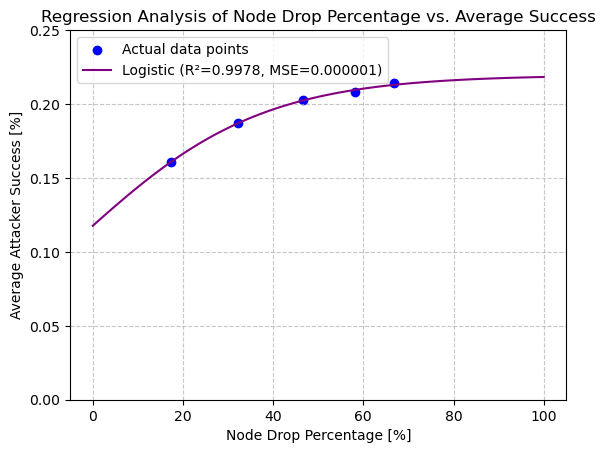

In [45]:
# Create a range of x values for prediction
x_range = np.linspace(0, 100, 100).reshape(-1, 1)

# Generate predictions for the range
y_pred_linear_range = linear_model.predict(x_range)
y_pred_poly_range = poly_model.predict(poly_features.transform(x_range))
y_pred_log_range = logarithmic_function(x_range.flatten(), a_fit, b_fit)
y_pred_logistic_range = logistic_function(x_range.flatten(), L_fit, k_fit, x0_fit)

# Plot the actual data points
plt.ylim(0, 0.25)
plt.scatter(X, y, color='blue', label='Actual data points')

# # Plot the regression lines
# plt.plot(x_range, y_pred_linear_range, color='red', 
#          label=f'Linear (R²={r2_linear:.4f}, MSE={mse_linear:.6f})')

# Plot the logistic regression curve
plt.plot(x_range, y_pred_logistic_range, color='purple', 
         label=f'Logistic (R²={r2_logistic:.4f}, MSE={mse_logistic:.6f})')

# # Plot the logarithmic regression curve
# plt.plot(x_range, y_pred_log_range, color='orange', 
#          label=f'Logarithmic (R²={r2_log:.4f}, MSE={mse_log:.6f})')

# Add labels and title
plt.xlabel('Node Drop Percentage [%]')
plt.ylabel('Average Attacker Success [%]')
plt.title('Regression Analysis of Node Drop Percentage vs. Average Success')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

In [39]:
def predict_success(drop_percentage, model_type='linear'):
    """
    Predict Average Success for given drop percentage.
    
    Parameters:
    drop_percentage (float or list): The drop percentage(s) to predict for
    model_type (str): 'linear', 'logistic', or 'logarithmic'
    
    Returns:
    float or array: Predicted Average Success value(s)
    """
    # Convert to numpy array if it's a list
    if isinstance(drop_percentage, list):
        dp_array = np.array(drop_percentage)
    else:
        dp_array = np.array([drop_percentage])
    
    if model_type.lower() == 'linear':
        return linear_model.predict(dp_array.reshape(-1, 1))
    elif model_type.lower() == 'logistic':
        return logistic_function(dp_array, L_fit, k_fit, x0_fit)
    elif model_type.lower() == 'logarithmic':
        return logarithmic_function(dp_array, a_fit, b_fit)
    else:
        raise ValueError("Model type must be 'linear', 'logistic', or 'logarithmic'")

In [43]:
# Example usage of the prediction function
test_percentages = [10, 20, 30, 40, 50, 60, 70]
print("\nPredictions for test percentages:")
print("Drop Percentage | Linear Prediction | Logistic Prediction | Logarithmic Prediction")
print("-" * 85)

for percentage in test_percentages:
    linear_pred = predict_success(percentage, 'linear')[0]
    logistic_pred = predict_success(percentage, 'logistic')[0]
    log_pred = predict_success(percentage, 'logarithmic')[0]
    print(f"{percentage:14} | {linear_pred:.6f} | {logistic_pred:.6f} | {log_pred:.6f}")


Predictions for test percentages:
Drop Percentage | Linear Prediction | Logistic Prediction | Logarithmic Prediction
-------------------------------------------------------------------------------------
            10 | 0.159028 | 0.143873 | 0.140239
            20 | 0.169409 | 0.166373 | 0.167387
            30 | 0.179790 | 0.183849 | 0.183317
            40 | 0.190171 | 0.196389 | 0.194633
            50 | 0.200552 | 0.204883 | 0.203416
            60 | 0.210933 | 0.210416 | 0.210595
            70 | 0.221314 | 0.213927 | 0.216667


In [ ]:
# Show the plot
plt.tight_layout()
plt.savefig('regression_plot.png')  # Save the plot to a file
plt.show()

# Print the model equations
linear_slope = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
print("\nLinear Regression Equation:")
print(f"Average Success = {linear_slope:.6f} × (Actual Drop Percentage) + {linear_intercept:.6f}")

print("\nLogistic Regression Equation:")
print(f"Average Success = {L_fit:.6f} / (1 + exp(-{k_fit:.6f} × (Actual Drop Percentage - {x0_fit:.6f})))")

print("\nLogarithmic Regression Equation:")
print(f"Average Success = {a_fit:.6f} + {b_fit:.6f} × log(Actual Drop Percentage + 0.1)")

<Figure size 640x480 with 0 Axes>


Linear Regression Equation:
Average Success = 0.001038 × (Actual Drop Percentage) + 0.148647

Logistic Regression Equation:
Average Success = 0.219607 / (1 + exp(-0.049782 × (Actual Drop Percentage - -2.890347)))

Logarithmic Regression Equation:
Average Success = 0.049011 + 0.039449 × log(Actual Drop Percentage + 0.1)
